# Import Libraries

In [70]:
import os
import sys
import config as cfg
import mysql.connector

import pandas as pd
import numpy as np
import math

# Environment variables
from dotenv import load_dotenv
load_dotenv("mysql.env")

#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# Model
from arch import arch_model
from arch.__future__ import reindexing

print('Machine: {} {}\n'.format(os.uname().sysname,os.uname().machine))
print(sys.version)

Machine: Darwin x86_64

3.8.12 | packaged by conda-forge | (default, Sep 16 2021, 01:59:00) 
[Clang 11.1.0 ]


# MySQL connection
Choosing one stock from SQL query to reduce query time.

In [119]:
HOST=os.environ.get("HOST")
PORT=os.environ.get("PORT")
USER=os.environ.get("USER")
PASSWORD=os.environ.get("PASSWORD")

try: 
    conn = mysql.connector.connect(
        host=HOST,
        port=PORT,
        user=USER,
        password=PASSWORD,
        database="GlobalMarketData"
    )
    query = "SELECT Date, Close, Open, High, Low, Volume from histdailyprice3 WHERE Symbol='XOP';"
    df = pd.read_sql(query, conn)
    conn.close()
except Exception as e:
    mydb.close()
    print(str(e))

# Data

In [120]:
df.head()

,Date,Close,Open,High,Low,Volume
0,2006-06-22,137.60,138.20,136.44,137.92,47800
1,2006-06-23,144.40,146.00,144.40,145.56,2900
2,2006-06-26,145.56,145.56,145.56,145.56,0
3,2006-06-27,149.00,149.00,147.52,147.88,12900
4,2006-06-28,148.16,149.84,148.16,149.84,35900


## Calculate Daily Returns
TODO: Consider compare the high and low.

The daily return at time $t$ can be modeled as follows:
$$ R_{t+1} = r + \lambda (w_t)h_{t+1} + \epsilon_{t+1}$$
$$ h_{t+1} = g(h_t, w_t, \epsilon_t) $$
where $ R_{t+1} $ is a single period return.

In [121]:
df['Return'] = 100 * (df['Close'].pct_change())

In [122]:
#abs(df["open"] - df["high"])
#abs(df["open"] - df["low"])

#100 * (df['High'].pct_change())
#100 * (df['Low'].pct_change())

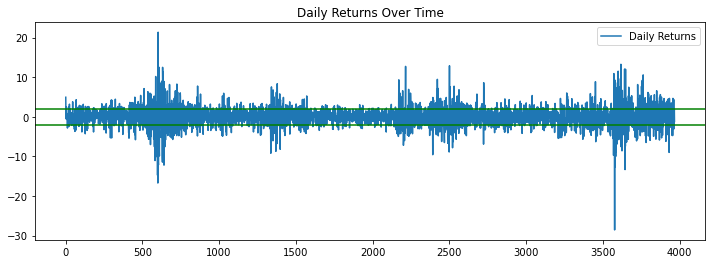

In [123]:
df.dropna(inplace=True)

fig = plt.figure()
fig.set_figwidth(12)
plt.plot(df['Return'], label = 'Daily Returns')
plt.axhline(y=2, color='g', linestyle='-')
plt.axhline(y=-2, color='g', linestyle='-')
plt.legend(loc='upper right')
plt.title('Daily Returns Over Time')
plt.show()

## Calculate daily, monthly, and annual volatitily

In [124]:
daily_volatility = df['Return'].std()
print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))

monthly_volatility = math.sqrt(21) * daily_volatility
print ('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))

annual_volatility = math.sqrt(252) * daily_volatility
print ('Annual volatility: ', '{:.2f}%'.format(annual_volatility ))

Daily volatility:  2.56%
Monthly volatility:  11.72%
Annual volatility:  40.58%


# ACF and PACF

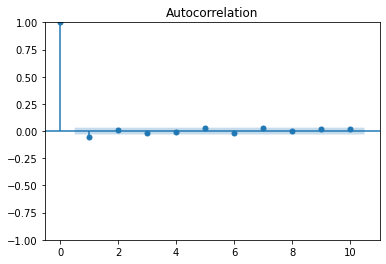

In [125]:
# create acf plot
plot_acf(df["Return"], lags=10)
plt.show()

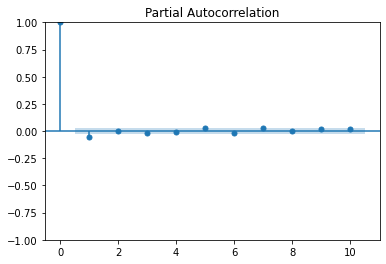

In [126]:
# create pacf plot
plot_pacf(df["Return"], lags=10, method='ywm')
plt.show()

In [127]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5, method="ywm")
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

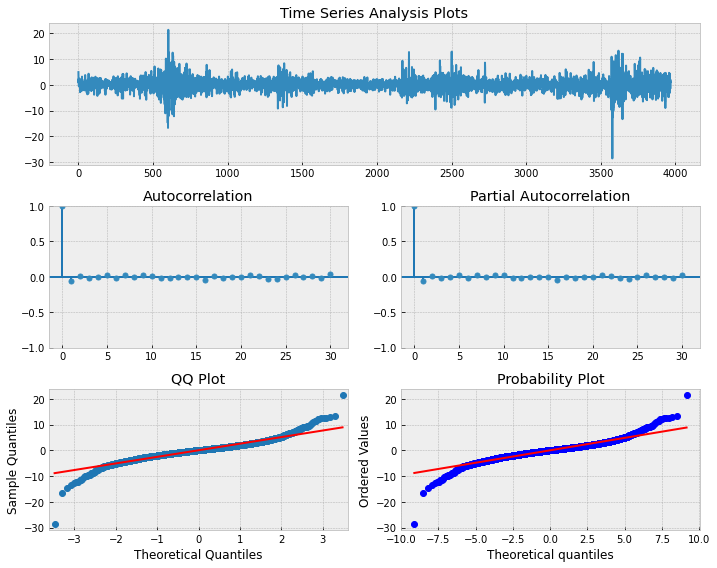

In [128]:
tsplot(df["Return"], lags=30)

# Train Test Split

In [129]:
# split into train/test
n_test = int(0.7 * len(df))
train, test = df[:-n_test], df[-n_test:]

## Predict Stock Volatilty using GARCH model
Generalized Auto Regressive Conditional Heteroskedasticity <br>

In [130]:
garch_model = arch_model(df['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
print(gm_result.params)

print('\n')

gm_forecast = gm_result.forecast(horizon = 5)
print(gm_forecast.variance[-1:])

mu          0.070679
omega       0.063675
alpha[1]    0.098980
beta[1]     0.892330
Name: params, dtype: float64


           h.1       h.2       h.3       h.4       h.5
3967  5.883919  5.896465  5.908903  5.921232  5.933454


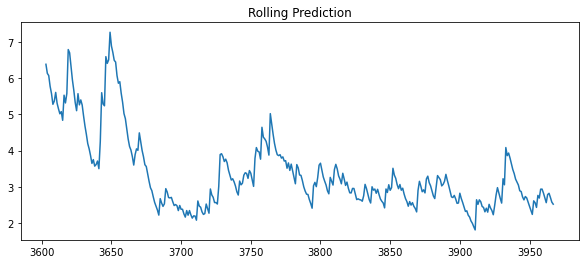

In [134]:
rolling_predictions = []
test_size = 365

# Parameters
p = 1
q = 1

for i in range(test_size):
    train = df['Return'][:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=df['Return'].index[-365:])

plt.figure(figsize=(10,4))
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')
plt.show()

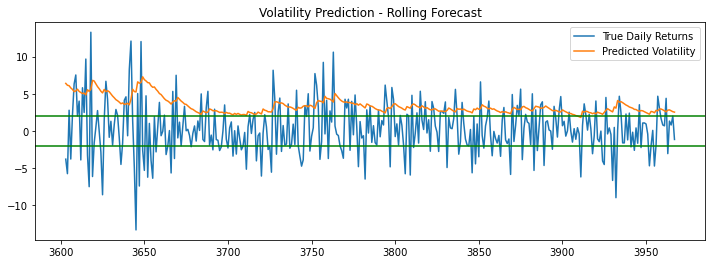

In [132]:
plt.figure(figsize=(12,4))
plt.plot(df['Return'][-365:])
plt.plot(rolling_predictions)
plt.axhline(y=2, color='g', linestyle='-')
plt.axhline(y=-2, color='g', linestyle='-')
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])
plt.show()

In [118]:
## Look at High and Low
## Number metrics, performance Confusion Matrix! (how many days it predicted correctly)
## AI ML 

## This stock i.e. TLT most of the time below 2% change, and we do not recommend this...

# Work Cited
Liu, Wing Ki, and Mike K. P. So. "A GARCH Model with Artifical Neural Networks." 20 Oct 2020.